In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

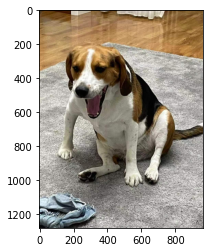

In [26]:
img = cv2.imread('beagle.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

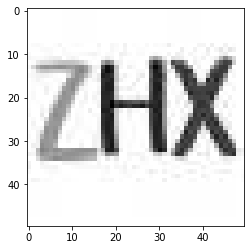

In [27]:
wm = cv2.imread('zhx.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(wm,cmap='gray')

In [28]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y


def corr2(a, b):
    """
    相关性判断
    """
    a = a - mean2(a)
    b = b - mean2(b)
    r = (a * b).sum() / np.sqrt((a * a).sum() * (b * b).sum())
    return r

In [29]:
alpha = 100
block_size = 4
k1 = np.random.randn(block_size)
k2 = np.random.randn(block_size)
wm = np.where(wm<np.mean(wm),0,1)
img = cv2.copyMakeBorder(img,
                        0,(block_size-(img.shape[0] % block_size)),
                        0,(block_size-(img.shape[1] % block_size)),
                        cv2.BORDER_REPLICATE)
img_backup = img.copy()
yuv_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
Y,U,V = yuv_img[...,0],yuv_img[...,1],yuv_img[...,2]
bk = U

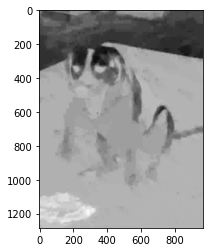

In [30]:
plt.imshow(bk,cmap="gray")

In [31]:
img_dct_blocks_h = bk.shape[0] // block_size
img_dct_blocks_w = bk.shape[1] // block_size
img_dct_blocks = np.zeros(shape=(
    (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
))

In [32]:
h_data = np.vsplit(bk,img_dct_blocks_h)

In [33]:
for h in range(img_dct_blocks_h):
    block_data = np.hsplit(h_data[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block = block_data[w]
        img_dct_blocks[h,w,...] = cv2.dct(a_block.astype(np.float64))

In [34]:
dct_embed_result = img_dct_blocks.copy()
for h in range(wm.shape[0]):
    for w in range(wm.shape[1]):
        k = k1 if wm[h,w] == 1 else k2
        for i in range(block_size):
            dct_embed_result[h,w,i,block_size-1] = \
            img_dct_blocks[h,w,i,block_size-1] + alpha * k[i]

In [35]:
row = None
idct_result = None
for h in range(dct_embed_result.shape[0]):
    for w in range(dct_embed_result.shape[1]):
        block = cv2.idct(dct_embed_result[h,w,...])
        row = block if w == 0 else np.hstack((row,block))
    idct_result = row if h == 0 else np.vstack((idct_result,row))

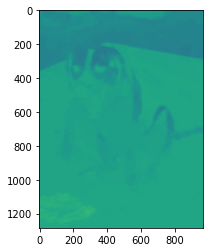

In [36]:
plt.imshow(idct_result,cmap="gray")

In [37]:
img_embed_result_yuv = np.stack((Y,idct_result,V),axis=2).astype(np.uint8)

In [38]:
img_embed_result_bgr = cv2.cvtColor(img_embed_result_yuv,cv2.COLOR_YUV2BGR)
img_embed_result = cv2.cvtColor(img_embed_result_bgr,cv2.COLOR_BGR2RGB)

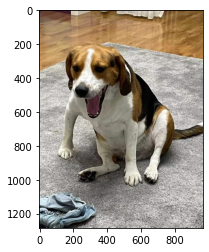

In [39]:
plt.imshow(img_embed_result)

In [40]:
recover_wm = np.zeros(shape=wm.shape)
img_dct_blocks_u = img_dct_blocks = np.zeros(shape=(
    (img_dct_blocks_h,img_dct_blocks_w,block_size,block_size)
))
h_data_u = np.vsplit(idct_result, img_dct_blocks_h)
for h in range(img_dct_blocks_h):
    block_data_u = np.hsplit(h_data_u[h],img_dct_blocks_w)
    for w in range(img_dct_blocks_w):
        a_block_u = block_data_u[w]
        img_dct_blocks_u[h,w,...] = cv2.dct(a_block_u.astype(np.float64))


In [41]:
p = np.zeros(block_size)
for h in range(wm.shape[0]):
    for w in range(wm.shape[1]):
        for k in range(block_size):
            p[k] = img_dct_blocks[h,w,k,block_size-1]
        if corr2(p,k1) > corr2(p,k2):
            recover_wm[h,w] = 1
        else:
            recover_wm[h,w] = 0


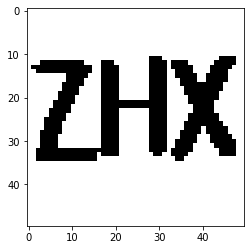

In [42]:
plt.imshow(recover_wm,cmap="gray")

In [43]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [44]:
origin_img = img
wmed_img = img_embed_result

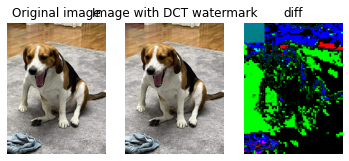

In [45]:
plt.subplot(1,3,1)
plt.imshow(origin_img)
plt.title('Original image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(wmed_img)
plt.title('Image with DCT watermark')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(wmed_img-origin_img)
plt.title('diff')
plt.axis('off')
plt.show()

In [46]:
origin_test = np.expand_dims(origin_img,axis=0)
wmed_test = np.expand_dims(wmed_img,axis=0)